
# Network Science (HS21)
## Assignment 7

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [34]:
import networkx as nx
import numpy as np
from numpy.typing import ArrayLike
from typing import Tuple, List
import matplotlib.pyplot as plt 

In [80]:
def compute_eigen(data: ArrayLike) -> Tuple[float, float]:
    return np.linalg.eig(data)

def marcenko_pasture_law(eigen: ArrayLike, Q: float) -> ArrayLike:
    sigma = 1
    lam = np.square(sigma) * (1 + (1 / Q))
    lambda_max = lam + 2 * np.sqrt(1 / Q)
    lambda_min = lam - 2 * np.sqrt(1 / Q)

    p = Q / (2 * np.pi * np.square(sigma)) * np.sqrt((lambda_max - eigen) * (eigen - lambda_min)) / eigen

    return p

def plot_hist(eigen, marcenko, label):
    plt.hist(eigen, label="eigen",density=True)
    plt.plot(marcenko, label="marcenko")
    plt.title(f"Eigen hist with marcenko_superimposed for {label}")
    plt.xlabel("value")
    plt.ylabel("count")
    plt.legend()
    plt.show()


def denoise_correlation_matrix(values: ArrayLike, vectors: ArrayLike) -> ArrayLike:
    D = np.diag(values)
    
    denoised = vectors @ D @ np.linalg.inv(vectors)
    return denoised

def solve_s01(data: ArrayLike, Q: float,label: str):
    values, vectors = compute_eigen(data)
    p = marcenko_pasture_law(values, Q)
    plot_hist(values, p, label)
    denoised = denoise_correlation_matrix(values, vectors)
    return denoised


In [9]:
h1 = np.load("data/cormat_1h.npy")
m1 = np.load("data/cormat_1m.npy")
with open("data/stocknames.txt", "r") as f:
    stocknames = [name.replace("\n","") for name in f.readlines()]

/tmp/ipykernel_334622/3181024959.py:10: RuntimeWarning: invalid value encountered in sqrt
  p = Q / (2 * np.pi * np.square(sigma)) * np.sqrt((lambda_max - eigen) * (eigen - lambda_min)) / eigen


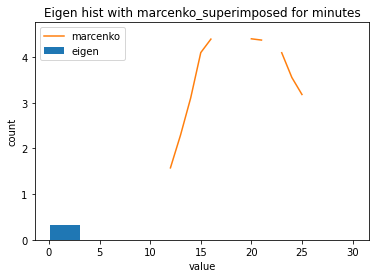

/tmp/ipykernel_334622/3181024959.py:10: RuntimeWarning: invalid value encountered in sqrt
  p = Q / (2 * np.pi * np.square(sigma)) * np.sqrt((lambda_max - eigen) * (eigen - lambda_min)) / eigen


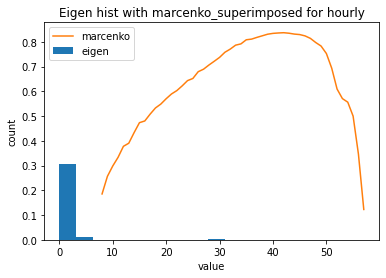

In [103]:
denoised_min = solve_s01(m1, 200.8969,"minutes")
denoised_hour = solve_s01(h1, 3.6289,"hourly")


# A07.2

In [104]:
from networkx.algorithms.tree.mst import minimum_spanning_tree

In [105]:
def plot_stock_scatter(minutes: ArrayLike, hours: ArrayLike):
    plt.scatter(minutes, hours)
    plt.title("Denoised")
    plt.xlabel("denoised minutes corr matrix")
    plt.ylabel("denoised hour corr matrix")
    plt.show()

def degrees_from_minimum_spanning_tree(data: ArrayLike, labels: List[str]):
    distance = np.sqrt(2*(1-data))
    graph = nx.from_numpy_array(distance)
    nx.set_node_attributes(graph, values=labels, name="ticker")
    mst = minimum_spanning_tree(graph)
    degrees = nx.degree()
    return degrees

In [106]:
print(type(denoised_min))
degrees_min = degrees_from_minimum_spanning_tree(denoised_min,stocknames)
print(type(denoised_hour))
degrees_hour = degrees_from_minimum_spanning_tree(denoised_hour, stocknames)
plt.scatter(degrees_min,degrees_hour)

<class 'numpy.ndarray'>


/tmp/ipykernel_334622/238258329.py:9: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt(2*(1-data))


TypeError: unhashable type: 'list'